**Цель**: Создать модель прогнозирования сумм внесений за день на горизонт 14 дней.

**Описание:** 

Для разработки модели клиент прислал данные о внесениях донатов. 
Для лучшего планирования финансовых ресурсов клиент хочет иметь в контуре модель, которая будет прогнозировать внесения на две недели вперёд. 
На данный момент аналитики на стороне клиента прикидывают объёмы внесений на 14 дней вперед, основываясь на «средних внесениях за прошедший период». 
Все исторические данные, которые есть у клиента, содержатся в файле. Клиент не откладывал тестовую выборку для проверки модели. 

Датасет data.csv содержит логи о начислении пожертвований. Необходимо обработать данные и построить модель для прогнозирования сумм пожертвований по дням на горизонт 14 дней. 
В датасете содержится два поля: 
-	date_time - дата и время произведённой транзакции
-	cash - сумма зачисленная в результате транзакции. 

# Часть 1. Отчёт по решённой задаче

Перед нами нестационарный временной ряд. Было проверено, что дата и время расположены в хрологическом порядке. Отсутствующих значений в ряде нет. Для проверки стационарности был выполнен тест Дики Фуллера, где поставили нулевую гипотезу, что ряд имеет единичный корень (ряд не является стационарным) и альтернативную гипотезу, что ряд не имеет единичного корня (является стационарным). Получили **p-value:  0.012 < 0.05**, что вроде бы позволяет отвергнуть нулевую гипотезу, однако, такое утверждение не всегда справедливо. Вывод о том, что ряд станционарный определили после сглаживания скользящей средней с окном **30**. Стало нгаглядно видно, что график имеет убывающий тренд и непостоянную дисперсию.

В силу того, что ряд является нестационарным при решении временных рядов его необходимо привести к стационарному. Был принят следующий алгоритм решения: 

* Была определена сезонная составляющая по декомпозированному графику и удалена из временного ряда (удалена недельная составляющая);
* Удалили тренд с помощью обычного дифференцирования;
* Получили стационарный ряд. Построили вектор признаков. Признаками являлись предыдущие значения (лаги), скользящая средняя и календарные признаки;
* Поделили полученный датасет на тренировочную и тестовую выборки (тестовая выборка - последний 14 дней, как требовалось по заданию);
* Обучили три модели: линейную регрессию, дерево решений в регрессии и случайный лес в регрессии на тренировочной выборке;
* Далее были получены предсказания трёх моделей;
* Для корректной оценки модели необходимо было восстановить исходный ряд: сначала вернули удалённый тренд в прогноз;
* Далее вернули удалённую ранее сезонность;
* Наши предсказания приняли вид нестационарного ряда, построили графики, сопоставили предсказания с тестовой выборкой, определили качества моделей коэффициентом детерминации.

**ВЫВОД**: Наилучшая модель для данной задачи - это **дерево решений в регрессии**. Был получен коэффициент детерминации **0.921**. Данную модель считаю состоятельной, так как коэффициент R2 больше 0,7, что свидетельствует о хорошем качестве модели. 

* *Для удобства все результирующие графики с коэффицентами детерминации в самом конце тетради*

# Часть 2. Код решения

## Загрузка данных и предобработка

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from numpy.linalg import inv
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

In [2]:
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable

In [3]:
data = pd.read_csv('C:/Users/Димантре/Desktop/Jupiter/тест/Data данные.csv')
data

,date_time,cash
0,2018-01-09T10:11:05Z,205146.000279
1,2018-01-09T13:19:10Z,152027.951693
2,2018-01-09T13:22:27Z,1910.088333
3,2018-01-09T13:23:30Z,181898.214643
4,2018-01-09T13:30:11Z,82061.541704
...,...,...
5163,2019-12-27T11:42:17Z,2513.274123
5164,2019-12-27T14:01:55Z,471.238898
5165,2019-12-28T13:24:11Z,44156.341383
5166,2019-12-28T13:26:05Z,140.115032


Исследуем диапазон значений:

<AxesSubplot:>

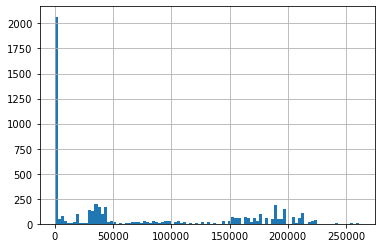

In [4]:
data['cash'].hist(bins=100)

Вглянем на распределение с помощью другого визуализатора:

E:\soft\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cash'>

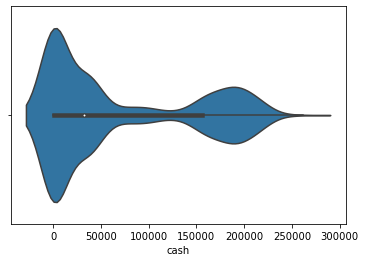

In [5]:
sns.violinplot(data['cash'])

In [6]:
data = pd.read_csv('C:/Users/Димантре/Desktop/Jupiter/тест/Data данные.csv', index_col=[0], parse_dates=[0])
data

,cash
date_time,
2018-01-09 10:11:05+00:00,205146.000279
2018-01-09 13:19:10+00:00,152027.951693
2018-01-09 13:22:27+00:00,1910.088333
2018-01-09 13:23:30+00:00,181898.214643
2018-01-09 13:30:11+00:00,82061.541704
...,...
2019-12-27 11:42:17+00:00,2513.274123
2019-12-27 14:01:55+00:00,471.238898
2019-12-28 13:24:11+00:00,44156.341383


Проверим, в хронологическом ли порядке расположены дата и время:

In [7]:
data.index.is_monotonic

True

In [8]:
data.head()

,cash
date_time,
2018-01-09 10:11:05+00:00,205146.000279
2018-01-09 13:19:10+00:00,152027.951693
2018-01-09 13:22:27+00:00,1910.088333
2018-01-09 13:23:30+00:00,181898.214643
2018-01-09 13:30:11+00:00,82061.541704


Сделаем ресемплирование по дню, как это просят сделать в задании. Для агрегации значений возьмём суммарное значение за день:

In [9]:
data = data.resample('1D').sum()
data

,cash
date_time,
2018-01-09 00:00:00+00:00,6.231349e+05
2018-01-10 00:00:00+00:00,4.189314e+05
2018-01-11 00:00:00+00:00,1.376951e+06
2018-01-12 00:00:00+00:00,1.013318e+06
2018-01-13 00:00:00+00:00,3.388264e+05
...,...
2019-12-24 00:00:00+00:00,6.657035e+05
2019-12-25 00:00:00+00:00,6.382145e+05
2019-12-26 00:00:00+00:00,4.517610e+05


## Анализ

Построим график нашего временного ряда:

<AxesSubplot:xlabel='date_time'>

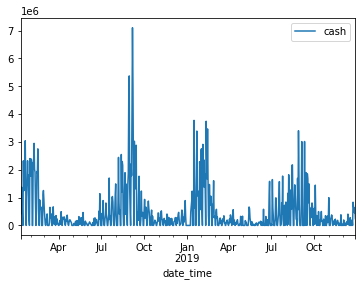

In [10]:
data.plot()

Построим скользящую среднюю для сглаживания ряда. Подберём размер окна так, чтобы график был читаем:

<AxesSubplot:xlabel='date_time'>

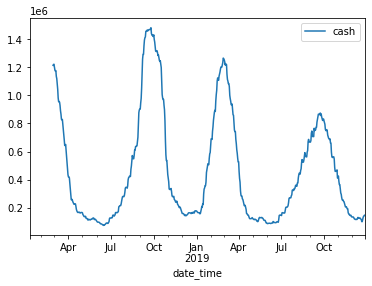

In [11]:
data.rolling(50).mean().plot()

Ряд не стационарный, так как видим убывающий тренд. Проверим это тестом Дики Фуллера:

**Тест Дики Фуллера**

In [12]:
test = sm.tsa.adfuller(data)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.3817092068585555
p-value:  0.01159843313640191
Critical values:  {'1%': -3.439753311961436, '5%': -2.8656896390914217, '10%': -2.568979777013325}
единичных корней нет, ряд стационарен


Ряд стационарен согласену результатам теста. Наш ряд будем всё же считать нестационарным из-за убывающего тренда и уменьшающейся дисперсии. 

Построим автокорреляционную и частичную автокорреляционную функцию:

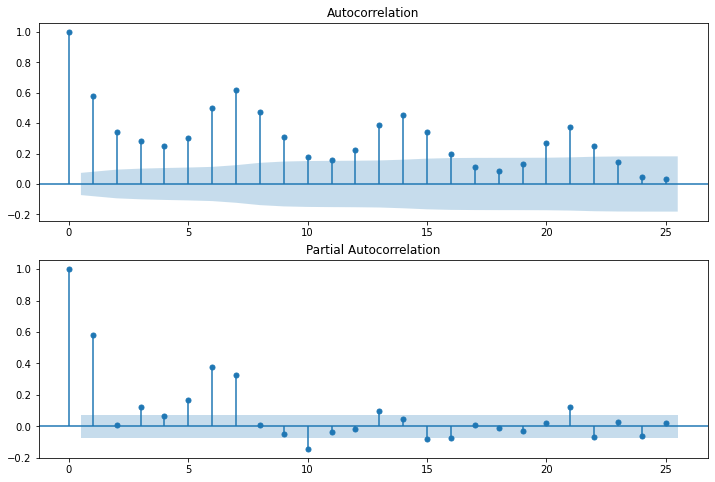

In [13]:
ig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=25, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=25, ax=ax2)

Посмотрим на тренд и сезонность:
* decomposed.trend — тренд;
* decomposed.seasonal — сезонная составляющая;
* decomposed.resid — остаток декомпозиции.

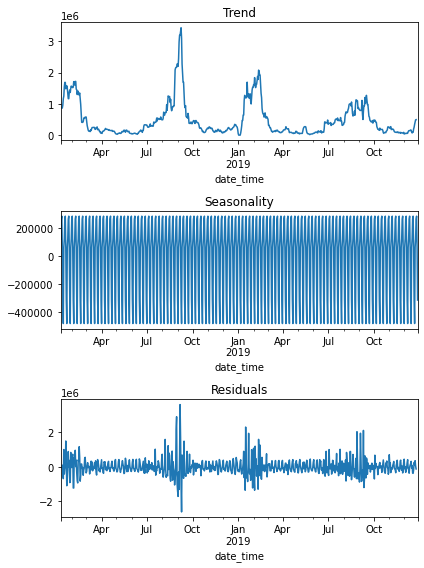

In [14]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Общий тренд идёт на снижение поступающих средств.
Построим график сезонной составляющей за первые 15 дней января 2018 года:

<AxesSubplot:xlabel='date_time'>

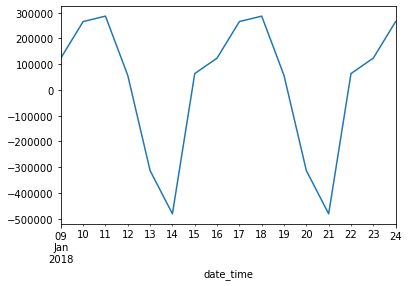

In [15]:
decomposed.seasonal['2018-01-09':'2018-01-24'].plot(ax=plt.gca())

Ближе к середине недели возрастают поступления средств. К выходным отсутствуют, что очевидно.

Теперь перейдем к сезонным составляющим. Для их оценки надо смотреть на лаги кратные размеру сезонности, т.е., если для нашего примера, сезонность равна 7, то надо рассматривать лаги 14, 21, 28 и т.д. Их видно на автокорреляционной функции. 

<AxesSubplot:xlabel='date_time'>

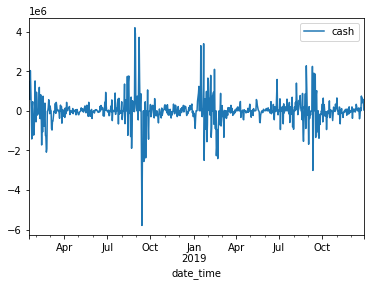

In [16]:
data_season = data - data.shift(7)
data_season = data_season.dropna()
data_season.plot()

In [17]:
test = sm.tsa.adfuller(data_season)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -6.334170821159896
p-value:  2.8576212390682696e-08
Critical values:  {'1%': -3.4398489271901713, '5%': -2.8657317673059395, '10%': -2.569002221596252}
единичных корней нет, ряд стационарен


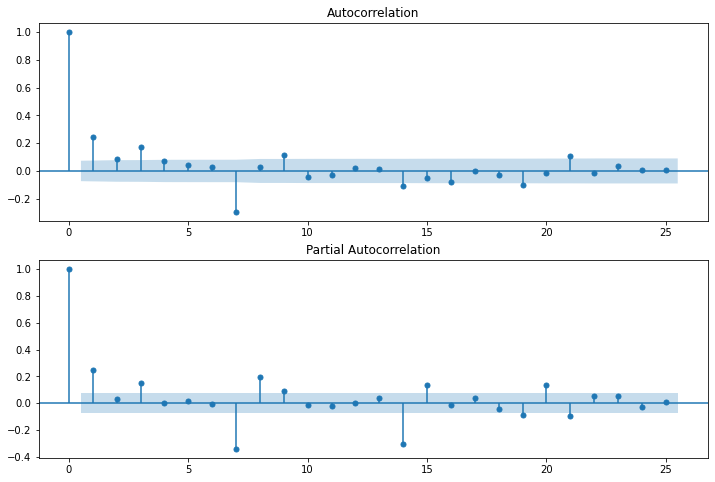

In [18]:
ig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data_season.values.squeeze(), lags=25, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_season, lags=25, ax=ax2)

Возьмём производную нашего датасета, чтобы сделать его стационарным. Повторим тест Дики Фуллера:

<AxesSubplot:xlabel='date_time'>

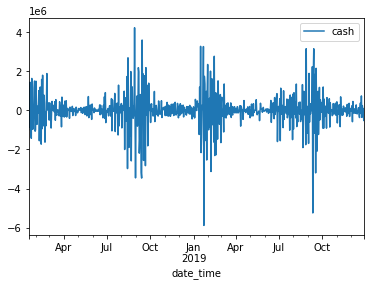

In [19]:
data_diff = data_season.diff(periods=1).dropna()
data_diff.plot()

In [20]:
test = sm.tsa.adfuller(data_diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -9.975029720262519
p-value:  2.189074529968822e-17
Critical values:  {'1%': -3.4398627454742488, '5%': -2.8657378555534248, '10%': -2.569005465238395}
единичных корней нет, ряд стационарен


Значение p-value теперь имеет несколько знаков после запятой. Будем считать ряд стационарным. Построим автокорреляционные цункции:

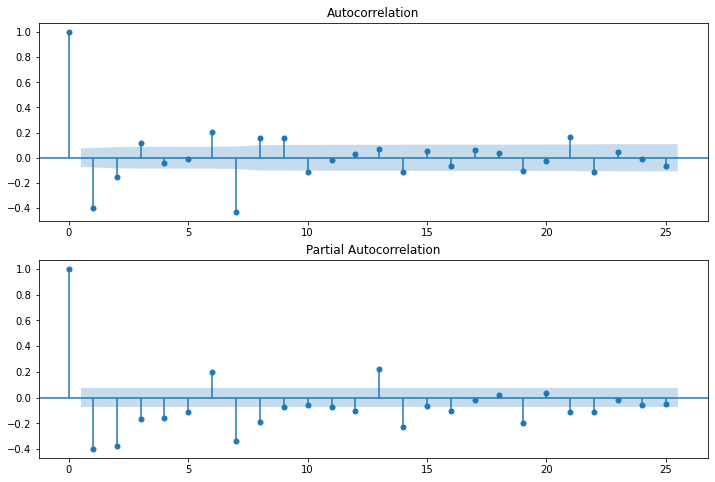

In [21]:
ig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data_diff.values.squeeze(), lags=25, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_diff, lags=25, ax=ax2)

**ВЫВОД:** Мы удалили тренд дифференцированием, убрали сезонность. В итоге получили стационарный ряд. Теперь можно обучать модель.

## Обучение и тестирование модели

Напишем функцию, чтобы задать календарные признаки, отстающие значения и скользящее среднее:

In [22]:
for i in range(14, 30):
    data_diff["lag_{}".format(i)] = data_diff.cash.shift(i)

In [23]:
def make_features(data, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    data['rolling_mean'] = data['lag_15'].shift().rolling(rolling_mean_size).mean()

In [24]:
make_features(data_diff, 15)

Разобъём датасет на обучающую и тестовую выборки:

In [25]:
train = data_diff.head(705)
train.head(10)

,cash,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,...,lag_25,lag_26,lag_27,lag_28,lag_29,year,month,day,dayofweek,rolling_mean
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-17 00:00:00+00:00,8.241843e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,1,17,2,NaN
2018-01-18 00:00:00+00:00,-8.658104e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,1,18,3,NaN
2018-01-19 00:00:00+00:00,1.448937e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,1,19,4,NaN
2018-01-20 00:00:00+00:00,-1.000044e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,1,20,5,NaN
2018-01-21 00:00:00+00:00,-1.028652e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,1,21,6,NaN
2018-01-22 00:00:00+00:00,-1.424654e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,1,22,0,NaN
2018-01-23 00:00:00+00:00,1.640004e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,1,23,1,NaN
2018-01-24 00:00:00+00:00,2.425718e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,1,24,2,NaN
2018-01-25 00:00:00+00:00,-9.682420e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,1,25,3,NaN


In [26]:
test = data_diff.tail(14)
test

,cash,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,...,lag_25,lag_26,lag_27,lag_28,lag_29,year,month,day,dayofweek,rolling_mean
date_time,,,,,,,,,,,,,,,,,,,,,
2019-12-15 00:00:00+00:00,-38833.226791,41154.863762,-40875.262016,110111.251712,-309410.748063,366152.623776,-164305.295783,-2827.433388,-85765.479443,310738.070959,...,-70999.993971,133831.847043,-63460.171603,44484.951975,67903.043349,2019,12,15,6,22443.747357
2019-12-16 00:00:00+00:00,5306.149992,-44296.456416,41154.863762,-40875.262016,110111.251712,-309410.748063,366152.623776,-164305.295783,-2827.433388,-85765.479443,...,71749.263819,-70999.993971,133831.847043,-63460.171603,44484.951975,2019,12,16,0,4748.875437
2019-12-17 00:00:00+00:00,138076.138718,240645.997265,-44296.456416,41154.863762,-40875.262016,110111.251712,-309410.748063,366152.623776,-164305.295783,-2827.433388,...,-296093.536805,71749.263819,-70999.993971,133831.847043,-63460.171603,2019,12,17,1,2965.663465
2019-12-18 00:00:00+00:00,-184537.152472,-577738.888995,240645.997265,-44296.456416,41154.863762,-40875.262016,110111.251712,-309410.748063,366152.623776,-164305.295783,...,310738.070959,-296093.536805,71749.263819,-70999.993971,133831.847043,2019,12,18,2,-2953.097094
2019-12-19 00:00:00+00:00,-363953.508918,460243.323751,-577738.888995,240645.997265,-44296.456416,41154.863762,-40875.262016,110111.251712,-309410.748063,366152.623776,...,-85765.479443,310738.070959,-296093.536805,71749.263819,-70999.993971,2019,12,19,3,17320.647497
2019-12-20 00:00:00+00:00,178256.480439,10053.096491,460243.323751,-577738.888995,240645.997265,-44296.456416,41154.863762,-40875.262016,110111.251712,-309410.748063,...,-2827.433388,-85765.479443,310738.070959,-296093.536805,71749.263819,2019,12,20,4,-30117.401572
2019-12-21 00:00:00+00:00,384088.604554,-133238.086031,10053.096491,460243.323751,-577738.888995,240645.997265,-44296.456416,41154.863762,-40875.262016,110111.251712,...,-164305.295783,-2827.433388,-85765.479443,310738.070959,-296093.536805,2019,12,21,5,5298.819609
2019-12-22 00:00:00+00:00,-157236.712312,44331.013935,-133238.086031,10053.096491,460243.323751,-577738.888995,240645.997265,-44296.456416,41154.863762,-40875.262016,...,366152.623776,-164305.295783,-2827.433388,-85765.479443,310738.070959,2019,12,22,6,1185.741787
2019-12-23 00:00:00+00:00,743649.538624,83252.205320,44331.013935,-133238.086031,10053.096491,460243.323751,-577738.888995,240645.997265,-44296.456416,41154.863762,...,-309410.748063,366152.623776,-164305.295783,-2827.433388,-85765.479443,2019,12,23,0,12042.771839


Удалим нулевые значения:

In [27]:
train = train.dropna()

Зададим обучающие признаки и целевой признак:

In [28]:
target_train = train['cash']
features_train = train.drop('cash', axis=1)
target_test = test['cash']
features_test = test.drop('cash', axis=1)

* Обучим модель **линейной регрессией:**

In [29]:
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
predictions_LR = model_LR.predict(features_test)

Обучили модель. Но наши предсказания необходимо вернуть в исходный график. То есть надо добавить тренд и сезонность. Только потом сможем сравнить с исходным датасетом. 

Создадим функцию для добавления тренда (используем обратную функцию дифференцированию - cumsum) и сезонности:

In [30]:
#Данная функция возвращает предсказания, к которым добавлен тренд (интегрирование ряда) и сезонность.
#Также в предсказании отрицательные значения заменены нулями, так как взносы не могут быть отрицательными по смыслу
def transform_prediction(prediction):
    prediction = np.cumsum(prediction)
    prediction = pd.DataFrame(data=prediction)
    prediction = data_season.tail(14).values + prediction.values
    prediction = pd.DataFrame(data=prediction)
    prediction[prediction < 0] = 0
    return prediction

Перезададим target_test на исходный нестационарный ряд:

In [31]:
target_test = data.tail(14)['cash']

Посчитаем R2:

In [32]:
R2 = r2_score(target_test, transform_prediction(predictions_LR))
R2

0.8819317433064656

Совместим графики исходного датасета и спрогнозированного:

Text(0.5, 0, 'Time Series, 14 days')

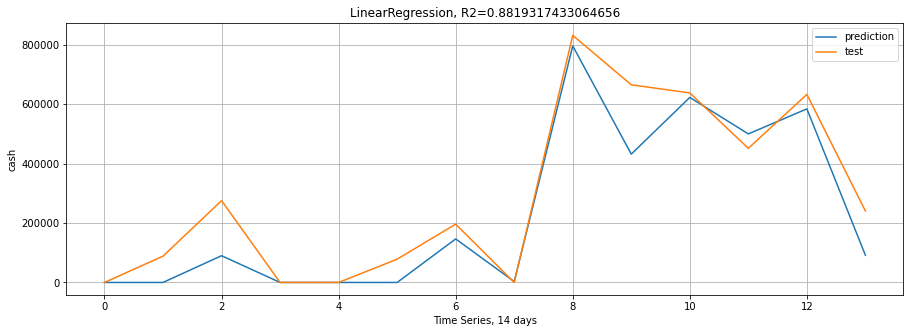

In [33]:
plt.figure(figsize=(15,5))
plt.title('LinearRegression, R2=' + str(R2))
plt.plot(transform_prediction(predictions_LR).values, label='prediction')
plt.plot(target_test.values, label='test')
plt.legend()
plt.grid(True)
plt.ylabel('cash')
plt.xlabel('Time Series, 14 days')

* Обучим модель **деревом решений**:

In [34]:
model_TreeReg = DecisionTreeRegressor(max_depth=8)
model_TreeReg.fit(features_train, target_train) 
predictions_TreeReg = model_TreeReg.predict(features_test)
R2_TreeReg = r2_score(target_test, transform_prediction(predictions_TreeReg))
R2_TreeReg

0.9209459651016305

Text(0.5, 0, 'Time Series, 14 days')

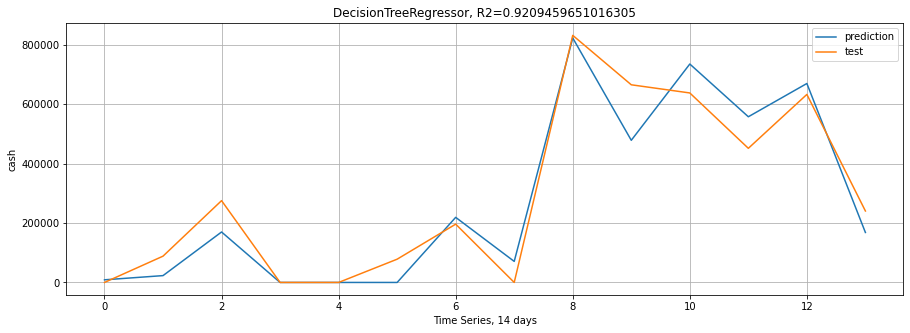

In [35]:
plt.figure(figsize=(15,5))
plt.title('DecisionTreeRegressor, R2=' + str(R2_TreeReg))
plt.plot(transform_prediction(predictions_TreeReg).values, label='prediction')
plt.plot(target_test.values, label='test')
plt.legend()
plt.grid(True)
plt.ylabel('cash')
plt.xlabel('Time Series, 14 days')

* Обучим модель **случайным лесом в регрессии**:

In [36]:
model_RFReg = RandomForestRegressor(n_estimators=6, max_depth=8)
model_RFReg.fit(features_train, target_train)
predictions_RFReg = model_RFReg.predict(features_test)
R2_RFReg = r2_score(target_test, transform_prediction(predictions_RFReg))
R2_RFReg

0.9174667249012598

Text(0.5, 0, 'Time Series, 14 days')

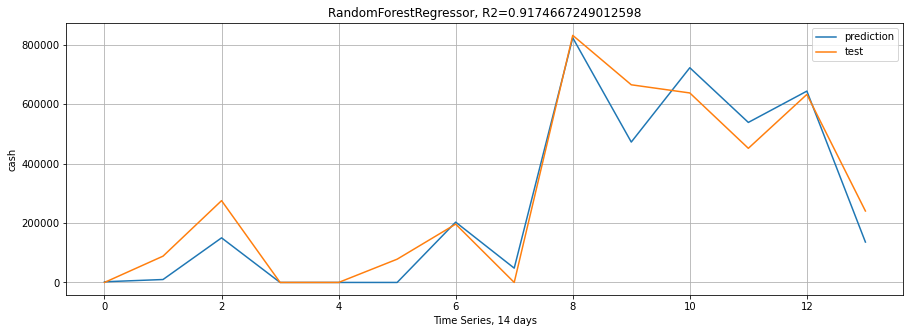

In [37]:
plt.figure(figsize=(15,5))
plt.title('RandomForestRegressor, R2=' + str(R2_RFReg))
plt.plot(transform_prediction(predictions_RFReg).values, label='prediction')
plt.plot(target_test.values, label='test')
plt.legend()
plt.grid(True)
plt.ylabel('cash')
plt.xlabel('Time Series, 14 days')

**ВЫВОД**: Наилучшая модель для данной задачи - это **дерево решений в регрессии**. Коэффициент детерминации **0.921**.